In [1]:
cd 'q:\dropbox\python\opencl-rotB\'

q:\dropbox\python\opencl-rotB


In [2]:
import pyopencl as cl
from pyopencl import array
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [76]:

class CL:
    def __init__(self, X, B):
        self.shape = X.shape[0:3]
        self.size = X.nbytes
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags
        self.fstr = "".join(open('rotB.cl', 'r').readlines())
        self.program = cl.Program(self.ctx, self.fstr).build()
        self.X = cl.Buffer(self.ctx, self.mf.READ_WRITE | self.mf.COPY_HOST_PTR, hostbuf=X)
        self.B = cl.Buffer(self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=B)
        self.J = cl.Buffer(self.ctx, self.mf.READ_WRITE, self.size*3)  
        
        self.temp = [cl.Buffer(self.ctx, self.mf.READ_WRITE, self.size) for i in range(0,3)]
        

               
    def rotB(self, X, out):
        self.program.Jacobian(self.queue, self.shape, None, X, self.J)
        self.program.rotB(self.queue, self.shape, None, X, self.J, self.B, out)
        return out  

    def Step(self, step):
        self.program.Flush(self.queue, self.shape, None, self.temp[2])
        
        self.rotB(self.X, self.temp[0]) ## F1
        self.program.Step(self.queue, self.shape, None, self.X, self.temp[0], np.float32(step*0.5), np.byte(1), self.temp[1]) ## X1 
        self.program.Step(self.queue, self.shape, None, self.temp[2], self.temp[0], np.float32(1/6.), np.byte(0), self.temp[2]) ## F
        
        self.rotB(self.temp[1], self.temp[0]) ## F2
        self.program.Step(self.queue, self.shape, None, self.X, self.temp[0], np.float32(step*0.5), np.byte(1), self.temp[1]) ## X2
        self.program.Step(self.queue, self.shape, None, self.temp[2], self.temp[0], np.float32(1/3.), np.byte(0), self.temp[2]) ## F
        
        self.rotB(self.temp[1], self.temp[0]) ## F3
        self.program.Step(self.queue, self.shape, None, self.X, self.temp[0], np.float32(step), np.byte(1), self.temp[1]) ## X3
        self.program.Step(self.queue, self.shape, None, self.temp[2], self.temp[0], np.float32(1/3.), np.byte(0), self.temp[2]) ## F  
        
        self.rotB(self.temp[1], self.temp[0]) ## F4
        self.program.Step(self.queue, self.shape, None, self.temp[2], self.temp[0], np.float32(1/6.), np.byte(0), self.temp[2]) ## F
        self.program.Step(self.queue, self.shape, None, self.X, self.temp[2], np.float32(step), np.byte(1), self.X) ## X
        return self
    
    def Iterate(self, step, niter):
        for i in range(0, niter):
            self.Step(step)
        return self
    
if __name__ == "__main__":

    dim = (32,32,32)
    idx = np.indices(dim).astype(np.float32)  
    X = np.zeros(dim+(4,), dtype = np.float32)
    X[:,:,:,0] = idx[0,:,:,:]
    X[:,:,:,1] = idx[1,:,:,:]
    X[:,:,:,2] = idx[2,:,:,:]
    
    X1 = np.array(X)
    ar = 4**2
    az = 2
    h = np.exp(-((X[:,:,:,0]-dim[0]/2)**2 + (X[:,:,:,1]-dim[1]/2)**2)/ar - (dim[2]-X[:,:,:,2])/az)*np.pi/2

    X[:,:,:,0] = (X1[:,:,:,0]-dim[0]/2)*np.cos(h) - (X1[:,:,:,1]-dim[1]/2)*np.sin(h) + dim[0]/2
    X[:,:,:,1] = (X1[:,:,:,0]-dim[0]/2)*np.sin(h) + (X1[:,:,:,1]-dim[1]/2)*np.cos(h) + dim[1]/2
    
    B = np.zeros(dim+(4,), dtype = np.float32)
    B[:,:,:,2] = np.ones(dim, dtype = np.float32)

    _CL = CL(X, B).Iterate(0.05, 900)
    
    X1 = np.zeros(dim + (4,), dtype = np.float32)
    cl.enqueue_read_buffer(_CL.queue, _CL.X, X1).wait()
    



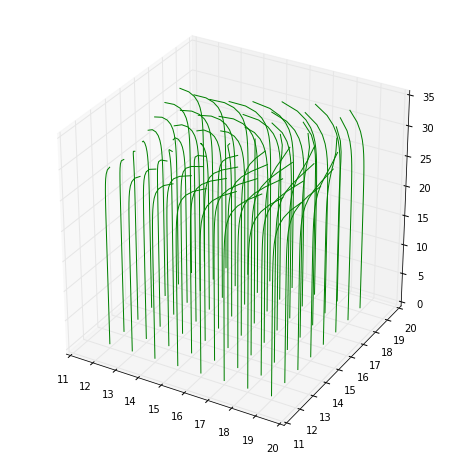

In [73]:
%matplotlib inline

fig = plt.figure(0,[8,8])
ax = fig.add_subplot(111, projection='3d')
for i in range(12,20,1):
    for j in range(12,20,1):
        ax.plot(X[i,j,:,0],X[i,j,:,1],X[i,j,:,2], color = 'green')
plt.show()

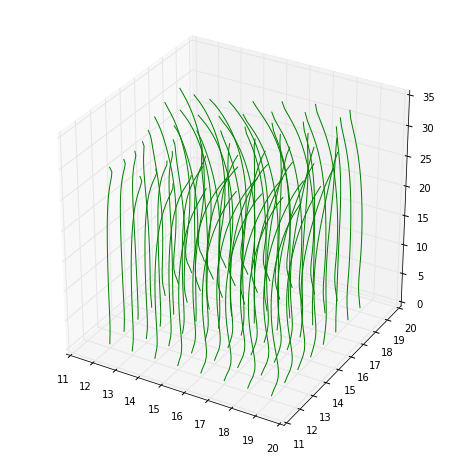

In [77]:
%matplotlib inline

fig = plt.figure(0,[8,8])
ax = fig.add_subplot(111, projection='3d')
for i in range(12,20,1):
    for j in range(12,20,1):
        ax.plot(X1[i,j,:,0],X1[i,j,:,1],X1[i,j,:,2], color = 'green')
plt.show()

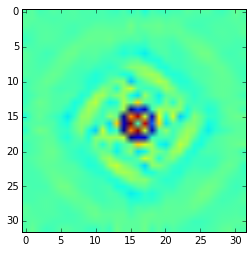

In [69]:
def det(a):
    return np.sum([a[0][i-1]*(a[1][i]*a[2][i+1]-a[1][i+1]*a[2][i]) for i in [1,-1,0]],0)

J = [np.gradient(X1[:,:,:,i], edge_order = 2) for i in range(0,3)]

detJ = det(J)
plt.imshow(detJ[:,:,2])

In [70]:
for i in range(0,32):
    print np.min(detJ[:,:,i])

0.949748
0.589663
0.30485
0.671218
0.835954
0.894857
0.937522
0.964609
0.972482
0.977896
0.980147
0.981873
0.984222
0.98559
0.985975
0.98559
0.985084
0.985101
0.985716
0.987016
0.988875
0.99091
0.990399
0.989142
0.987865
0.986526
0.985974
0.985958
0.986873
0.988039
0.987304
1.0


In [1]:
0.6**(0.1)

0.9502002165056764